# Tinkoff RecSys

## Imports

In [18]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

## Data

In [19]:
data_folder = ""

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()


In [20]:
users_df

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,721985,age_45_54,income_20_40,Ж,0
3,704055,age_35_44,income_60_90,Ж,0
4,846063,age_35_44,income_40_60,Ж,1
...,...,...,...,...,...
366083,848247,age_18_24,income_20_40,Ж,0
366084,950528,age_35_44,income_20_40,М,1
366085,1021167,age_65_inf,income_20_40,Ж,0
366086,312839,age_65_inf,income_60_90,Ж,0


In [21]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366088 entries, 0 to 366087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   366088 non-null  int64 
 1   age       362506 non-null  object
 2   income    362739 non-null  object
 3   sex       362027 non-null  object
 4   kids_flg  366088 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 14.0+ MB


Заполнил пропуски самым частым элементом

In [22]:
users_df = users_df.apply(lambda x:x.fillna(x.value_counts().index[0]))

Рассмотрим распределния значений параметров пользователей

<AxesSubplot:>

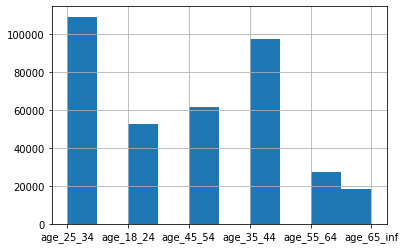

In [23]:
users_df['age'].hist()

<AxesSubplot:>

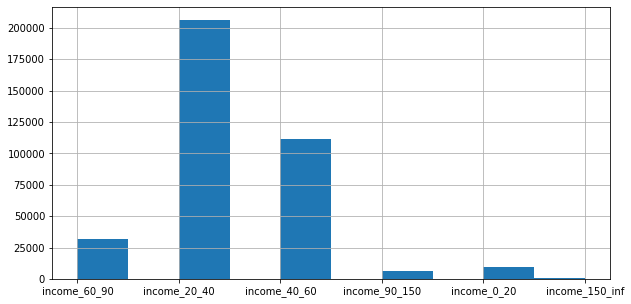

In [24]:
users_df['income'].hist(figsize = (10, 5))

<AxesSubplot:>

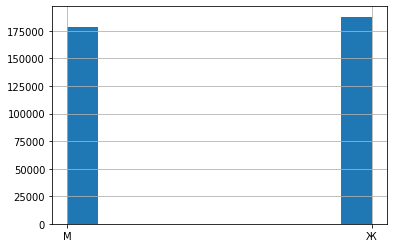

In [25]:
users_df['sex'].hist()

<AxesSubplot:>

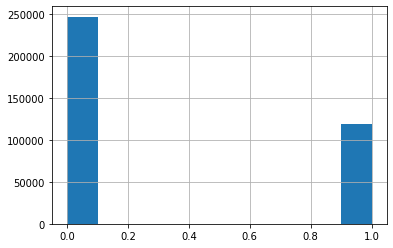

In [26]:
users_df['kids_flg'].hist()

Пока что никаких конкретных выводов из распредлений я не сделал, данные выглядят весьма логично, анамалий нет. Но возможно в будущем при построении определенной модели, нам смогут помочь знания о этих рапределниях.

Стоит заметить, что признаки категориальные, но их легко пределать в количетвенные, так как количество категорий конечно. Нам понадобитьсся это сделать когда мы захотим считать схожесть пользователей, но пока что не будем менять и поменяем таблицу, когда нам нужно будет.

Так же из того что категорий конечное число явно напрашивается кластеризация пользователей, этим и анализом получившихся кластеров мы займемся позже.

In [27]:
items_df

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,"The Swan Princess: Princess Tomorrow, Pirate T...",2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,NaN,6.0,Sony Pictures,Ричард Рич,"Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, Д...",Анимационная сказка о непоседливой принцессе Э...,"Принцесса, Лебедь, Пират, или, принцесса, 2016..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12062,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н..."
12063,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
12064,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
12065,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


In [28]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12067 entries, 0 to 12066
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       12067 non-null  int64  
 1   content_type  12067 non-null  object 
 2   title         12067 non-null  object 
 3   title_orig    9144 non-null   object 
 4   release_year  12019 non-null  float64
 5   genres        12067 non-null  object 
 6   countries     12051 non-null  object 
 7   for_kids      528 non-null    float64
 8   age_rating    12066 non-null  float64
 9   studios       749 non-null    object 
 10  directors     11160 non-null  object 
 11  actors        10268 non-null  object 
 12  description   12066 non-null  object 
 13  keywords      11705 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.3+ MB


Исследуем пропуски

In [29]:
items_df[['countries', 'title_orig']][items_df['title_orig'].isna()]['countries'].unique()

array(['Россия', 'СССР', 'Республика Корея', 'Новая Зеландия',
       'Великобритания', 'Швеция', 'США', 'Казахстан', 'Украина',
       'Канада', 'Япония', 'Италия', 'Ирландия', 'Испания',
       'Великобритания, США, Канада', 'Франция', 'Нидерланды', 'Армения',
       'Беларусь', 'Россия, Украина', 'Турция', 'Индия', 'Бразилия',
       'Россия, США', 'Китай', 'Австралия', 'Киргизия', nan, 'Бельгия',
       'Колумбия', 'Аргентина', 'Дания',
       'США, Нидерланды, Аргентина, Франция', 'Россия, Франция',
       'Мексика', 'Норвегия', 'Россия, Великобритания, Австрия', 'Польша',
       'Хорватия, Люксембург, Норвегия, Чехия, Словакия, Словения',
       'Германия', 'Индонезия', 'Словения', 'Узбекистан', 'Швейцария',
       'Финляндия', 'Португалия', 'Коста-Рика', 'Малайзия', 'Кипр',
       'Перу'], dtype=object)

In [30]:
#items_df[items_df['title_orig'].isna()][]

<AxesSubplot:>

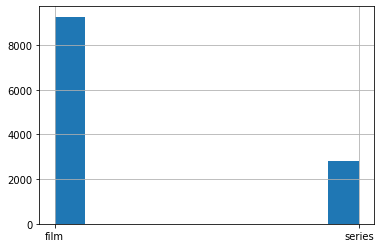

In [31]:
items_df['content_type'].hist()

In [32]:
train_part

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1224555,207142,15297,2021-07-19,24915.0,88.0
1224556,63645,16373,2021-04-20,30964.0,100.0
1224557,90242,15739,2021-07-27,12265.0,100.0
1224558,32937,10954,2021-05-13,71.0,1.0


In [33]:
train_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224560 entries, 0 to 1224559
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        1224560 non-null  int64         
 1   item_id        1224560 non-null  int64         
 2   last_watch_dt  1224560 non-null  datetime64[ns]
 3   total_dur      1224560 non-null  float64       
 4   watched_pct    1224295 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 46.7 MB


In [34]:
#TODO Data Ingenerind + some graphics

## Metrics

In [35]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

## Abstract model class

In [36]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

## Models

### Baseline

In [37]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
base_toppop = test_part.copy()
base_toppop["toppopular_recs"] = toppop.predict(test_part)
base_toppop.head()

,user_id,ground_truth,toppopular_recs
0,30,"[8584, 3031, 15363]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
1,144,"[3800, 11987, 10942]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
2,241,"[14841, 6162, 5808, 15266]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
4,475,"[6214, 3734, 6686]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."


In [38]:
evaluate_recommender(df=base_toppop, model_preds_col="toppopular_recs")


{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

In [39]:
train_part

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1224555,207142,15297,2021-07-19,24915.0,88.0
1224556,63645,16373,2021-04-20,30964.0,100.0
1224557,90242,15739,2021-07-27,12265.0,100.0
1224558,32937,10954,2021-05-13,71.0,1.0


In [40]:
top_10_popular = train_part['item_id'].value_counts().index.values[:10]
top_10_popular

array([10440, 15297, 13865,  9728,  4151,  2657,  3734,  4880,   142,
        6809], dtype=int64)

### Clasterisation + popularaty

Попробуем развить идею безлайна, а именно разбить множетво пользователей на кластеры и сопотавлять топ популярных фильмов уже внутри кластера. Пользователям, о которых нет информации или чей клстер слишком маленький, будем сопоставлять просто топ 10 популярных.

Все признаки пользователя екатегориальные, а значик количество различных характеритик пользователя конечно, то есть класстеризация напрашивается
сама собой

In [41]:
users_clasters = users_df.groupby(['age', 'income', 'sex', 'kids_flg'])['user_id'].count()

Рассмотрим, какие кластеры у нас получились и сколько там пользователей

In [42]:
claster_df = pd.DataFrame({'type': list(users_clasters.index), 'count': users_clasters.values})
print(claster_df.sort_values(['count'], ascending=False).to_string())

                                   type  count
31      (age_25_34, income_20_40, Ж, 0)  27807
7       (age_18_24, income_20_40, Ж, 0)  20717
33      (age_25_34, income_20_40, М, 0)  17786
55      (age_35_44, income_20_40, Ж, 0)  13269
37      (age_25_34, income_40_60, М, 0)  12032
56      (age_35_44, income_20_40, Ж, 1)  11837
62      (age_35_44, income_40_60, М, 1)  11657
57      (age_35_44, income_20_40, М, 0)  11087
9       (age_18_24, income_20_40, М, 0)  10898
79      (age_45_54, income_20_40, Ж, 0)  10522
35      (age_25_34, income_40_60, Ж, 0)  10294
32      (age_25_34, income_20_40, Ж, 1)  10132
58      (age_35_44, income_20_40, М, 1)  10091
61      (age_35_44, income_40_60, М, 0)  10069
81      (age_45_54, income_20_40, М, 0)   9753
85      (age_45_54, income_40_60, М, 0)   8731
103     (age_55_64, income_20_40, Ж, 0)   7837
34      (age_25_34, income_20_40, М, 1)   7078
60      (age_35_44, income_40_60, Ж, 1)   7045
105     (age_55_64, income_20_40, М, 0)   6993
127    (age_6

Определим топ 10 фильмов для каждого кластера

In [43]:
groups = users_df.groupby(['age', 'income', 'sex', 'kids_flg'])['user_id'].apply(list).values

In [44]:
top_ten = []
for group in groups:
    items = train_part[train_part['user_id'].isin(group)]['item_id'].value_counts().index.values
    if len(items) < 20:
        top_ten.append(top_10_popular)
    else:
        top_ten.append(items[:10])
claster_df['top_ten'] = top_ten

In [45]:
print(claster_df.sort_values('count',  ascending=False).to_string())

                                   type  count                                                              top_ten
31      (age_25_34, income_20_40, Ж, 0)  27807       [15297, 10440, 9728, 13865, 4151, 3734, 2657, 4880, 142, 6809]
7       (age_18_24, income_20_40, Ж, 0)  20717     [15297, 10440, 9728, 4151, 2657, 3734, 13865, 4880, 6809, 14431]
33      (age_25_34, income_20_40, М, 0)  17786     [9728, 10440, 13865, 15297, 3734, 4151, 4880, 2657, 6809, 11237]
55      (age_35_44, income_20_40, Ж, 0)  13269       [10440, 15297, 13865, 9728, 3734, 4151, 2657, 142, 4880, 8636]
37      (age_25_34, income_40_60, М, 0)  12032       [9728, 13865, 10440, 15297, 4151, 3734, 6809, 4880, 2657, 142]
56      (age_35_44, income_20_40, Ж, 1)  11837       [15297, 10440, 13865, 9728, 4151, 3734, 2657, 142, 4880, 8636]
62      (age_35_44, income_40_60, М, 1)  11657      [13865, 9728, 10440, 15297, 3734, 4880, 4151, 8636, 12995, 142]
57      (age_35_44, income_20_40, М, 0)  11087     [10440, 13865, 9728, 

In [46]:
top_10_popular

array([10440, 15297, 13865,  9728,  4151,  2657,  3734,  4880,   142,
        6809], dtype=int64)

Надо заметить, что полученные рекомендации не сильно отличаются от топ 10 по вссем пользователям, меняется порядок и возможно появляется несколько других фильмов

In [47]:
def foo(x):
    return len(set(x).symmetric_difference(set(top_10_popular))) / 2
print(pd.DataFrame({'count': claster_df['count'], 'top_ten_sym_dif': claster_df['top_ten'].apply(foo)}).sort_values('count', ascending=False).to_string())

     count  top_ten_sym_dif
31   27807              0.0
7    20717              1.0
33   17786              1.0
55   13269              1.0
37   12032              0.0
56   11837              1.0
62   11657              2.0
57   11087              2.0
9    10898              1.0
79   10522              1.0
35   10294              0.0
32   10132              1.0
58   10091              1.0
61   10069              1.0
81    9753              1.0
85    8731              2.0
103   7837              1.0
34    7078              1.0
60    7045              1.0
105   6993              1.0
127   6696              2.0
59    6390              1.0
38    6198              1.0
83    5115              1.0
86    5053              1.0
80    4930              1.0
36    4865              0.0
129   4505              2.0
66    4431              2.0
8     4386              1.0
82    4331              1.0
11    3934              0.0
109   3851              2.0
13    3463              1.0
65    3425          

In [48]:
ind_by_user = {}
for i, group in enumerate(groups):
    for user in group:
        ind_by_user[user] = i

        

In [49]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.pop_item_by_group = []
        self.recommendations = df[item_id_col].value_counts().index.values
        for group in groups:
            items = df[df['user_id'].isin(group)][item_id_col].value_counts().index.values
            if len(items) < 20:
                self.pop_item_by_group.append(self.recommendations)
            else:
                self.pop_item_by_group.append(items)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        
        return df['user_id'].apply(lambda x: self.pop_item_by_group[ind_by_user[x]][:topn] if x in ind_by_user.keys() else self.recommendations[:topn]).values


toppop = TopPopular()
toppop.fit(train_part)
base_toppop = test_part.copy()
base_toppop["toppopular_recs"] = toppop.predict(test_part)
base_toppop.head()

,user_id,ground_truth,toppopular_recs
0,30,"[8584, 3031, 15363]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
1,144,"[3800, 11987, 10942]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
2,241,"[14841, 6162, 5808, 15266]","[15297, 10440, 9728, 4151, 13865, 3734, 6809, ..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
4,475,"[6214, 3734, 6686]","[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."


In [50]:
evaluate_recommender(df=base_toppop, model_preds_col="toppopular_recs")

{'ndcg': 0.1700312759511532, 'recall': 0.07629950088022809}

Как можно понять из анализа популярных фильмов внутри клстера, рекомендации для больщих почти не меняютсяс, а маленькие нам особо погоды не делают, а метрики стали даже хуже

### Matrix Factorisation

Попоробуем менее наивный подход, осснованный на на факторизации(разложении в произведение) матрицы взаимодействий пользователей. начала попробуем более наивный подход SVD, а потом модель ALS

#### ALS

In [51]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [52]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)


  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [53]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

### EASE

In [54]:
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count


class EASE:
    def __init__(self):
        self.user_enc = LabelEncoder()
        self.item_enc = LabelEncoder()

    def _get_users_and_items(self, df):
        users = self.user_enc.fit_transform(df.loc[:, 'user_id'])
        items = self.item_enc.fit_transform(df.loc[:, 'item_id'])
        return users, items

    def fit(self, df, lambda_: float = 0.5, implicit=True):
        """
        df: pandas.DataFrame with columns user_id, item_id and (rating)
        lambda_: l2-regularization term
        implicit: if True, ratings are ignored and taken as 1, else normalized ratings are used
        """
        users, items = self._get_users_and_items(df)
        values = (
            np.ones(df.shape[0])
            if implicit
            else df['rating'].to_numpy() / df['rating'].max()
        )

        X = csr_matrix((values, (users, items)))
        self.X = X

        G = X.T.dot(X).toarray()
        diagIndices = np.diag_indices(G.shape[0])
        G[diagIndices] += lambda_
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diagIndices] = 0

        self.B = B
        self.pred = X.dot(B)

    def predict(self, train, users, items, k):
        items = self.item_enc.transform(items)
        dd = train.loc[train.user_id.isin(users)]
        dd['ci'] = self.item_enc.transform(dd.item_id)
        dd['cu'] = self.user_enc.transform(dd.user_id)
        g = dd.groupby('cu')
        with Pool(cpu_count()) as p:
            user_preds = p.starmap(
                self.predict_for_user,
                [(user, group, self.pred[user, :], items, k) for user, group in g],
            )
        df = pd.concat(user_preds)
        df['item_id'] = self.item_enc.inverse_transform(df['item_id'])
        df['user_id'] = self.user_enc.inverse_transform(df['user_id'])
        return df

    @staticmethod
    def predict_for_user(user, group, pred, items, k):
        watched = set(group['ci'])
        candidates = [item for item in items if item not in watched]
        pred = np.take(pred, candidates)
        res = np.argpartition(pred, -k)[-k:]
        r = pd.DataFrame(
            {
                "user_id": [user] * len(res),
                "item_id": np.take(candidates, res),
                "score": np.take(pred, res),
            }
        ).sort_values('score', ascending=False)
        return r

In [55]:
train_part

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1224555,207142,15297,2021-07-19,24915.0,88.0
1224556,63645,16373,2021-04-20,30964.0,100.0
1224557,90242,15739,2021-07-27,12265.0,100.0
1224558,32937,10954,2021-05-13,71.0,1.0


In [56]:
#ease = EASE()
#ease.fit(train_part)


In [ ]:
#pred = ease.predict(train_part, test_part['user_id'], train_part['item_id'], 10)

C:\Users\vsevo\AppData\Local\Temp\ipykernel_16028\740626485.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['ci'] = self.item_enc.transform(dd.item_id)
C:\Users\vsevo\AppData\Local\Temp\ipykernel_16028\740626485.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['cu'] = self.user_enc.transform(dd.user_id)
